# Capstone Project 

## The Battle of Neighborhoods (Toronto Non-Private Schools)

In [373]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests 

import lxml.html as lh

#!conda install -c conda-forge geocoder --yes # uncomment this line if you haven't completed the Foursquare API lab
#import geocoder
import sys

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


import datetime
curtime = datetime.datetime.today().strftime('%Y-%m-%d')

print('Libraries imported.')

Libraries imported.


## 1. Get the List of postal codes of Canada from Wikipedia

In [374]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

page = requests.get(url)
doc = lh.fromstring(page.content)

tr_elements = doc.xpath('//tr') #Parse data that are stored between <tr>..</tr> of HTML

[len(T) for T in tr_elements[:10]] # check number of columns for first 10 rows

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [375]:
dataset=[]
for j in range(1,len(tr_elements)):
    line = []
    for t in tr_elements[j].iterchildren():
        line.append(t.text_content().strip())
    
    if len(line) == 3 and line[0] != '' and line[1] != 'Not assigned':
        dataset.append(line)

List_of_postcode = pd.DataFrame(dataset,columns=['PostalCode', 'Borough', 'Neighborhood'])


In [376]:
List_of_postcode.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [377]:

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "1a714b5c-64c0-4cdf-9739-0086f80fb3ee"}
package = requests.get(url, params = params).json()

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        data = requests.get(url, params = p).json()
        df = pd.DataFrame(data["result"]["records"])
        break


In [378]:
df.columns = [str(x).lower() for x in df.columns]
df.head()

,_id,objectid,geo_id,name,school_level,school_type,board_name,source_address,school_type_desc,address_point_id,address_number,linear_name_full,address_full,postal_code,municipality,city,place_name,general_use_code,centreline_id,lo_num,lo_num_suf,hi_num,hi_num_suf,linear_name_id,x,y,latitude,longitude,geometry
0,15558,1,7963754,Avondale Public School,None,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,None,None,None,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674..."
1,15559,2,7315504,Avondale Secondary Alternative School,None,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,None,None,None,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315..."
2,15560,3,20258267,AYJ Global Academy,None,PR,None,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,None,104008,438287,4,None,None,None,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641..."
3,15561,4,7102999,Bais Brucha School,None,PR,None,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,None,104008,7102975,3077,None,None,None,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699..."
4,15562,5,9171677,Bais Chaya Mushka Elementary School,None,PR,None,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,None,115001,9171675,4375,None,None,None,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198..."


In [379]:
df.dropna(subset=['postal_code'],inplace=True)

df = df[['name','school_type_desc', 'address_full', 'postal_code','municipality', 'latitude', 'longitude']]

datadf = df.assign(postalcode=[x.split(' ')[0] for x in df['postal_code'].to_list()]).drop(columns=['postal_code'])

datadf[:2]


,name,school_type_desc,address_full,municipality,latitude,longitude,postalcode
0,Avondale Public School,English Public,25 Bunty Lane,North York,43.776502,-79.385190,M2K
1,Avondale Secondary Alternative School,English Public,24 Silverview Dr,North York,43.786315,-79.411846,M2M


In [380]:
datadf_merged_left = pd.merge(left=datadf, right=List_of_postcode, how='left', left_on='postalcode', right_on='PostalCode')
datadf_merged_left[:2]

,name,school_type_desc,address_full,municipality,latitude,longitude,postalcode,PostalCode,Borough,Neighborhood
0,Avondale Public School,English Public,25 Bunty Lane,North York,43.776502,-79.385190,M2K,M2K,North York,Bayview Village
1,Avondale Secondary Alternative School,English Public,24 Silverview Dr,North York,43.786315,-79.411846,M2M,M2M,North York,"Willowdale, Newtonbrook"


In [381]:
datadf_merged_left.school_type_desc.value_counts()

English Public      46
Priv                42
English Separate    10
French Separate      1
Name: school_type_desc, dtype: int64

__Count Number of Private and Non Private Schools in each Municipality__

In [382]:
datadf_merged_left['school_type_desc'].mask(datadf_merged_left['school_type_desc'] != 'Priv', 'Non Private', inplace=True)

school_type = datadf_merged_left.groupby(['municipality','school_type_desc'])["name"].count().reset_index()

school_type.columns= ['municipality','school_type_desc', 'count_of_schools']


In [383]:
school_type.sort_values(by=['municipality','count_of_schools'], ascending = False)

,municipality,school_type_desc,count_of_schools
8,former Toronto,Non Private,15
9,former Toronto,Priv,12
6,York,Non Private,2
7,York,Priv,2
4,Scarborough,Non Private,16
5,Scarborough,Priv,5
3,North York,Priv,23
2,North York,Non Private,13
1,Etobicoke,Non Private,9
0,East York,Non Private,2


In [384]:
non_private_schools = datadf_merged_left[datadf_merged_left['school_type_desc'] != 'Priv'].reset_index(drop=True)
non_private_schools = non_private_schools[['name', 'school_type_desc', 'address_full', 'municipality', 'latitude',
       'longitude', 'postalcode', 'Borough', 'Neighborhood']]

In [385]:
non_private_schools.columns

Index(['name', 'school_type_desc', 'address_full', 'municipality', 'latitude',
       'longitude', 'postalcode', 'Borough', 'Neighborhood'],
      dtype='object')

In [386]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")     
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of {address} are {latitude}, {longitude}.')

The geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


In [387]:
# create map of North York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, address_full, borough in zip(non_private_schools['latitude'], non_private_schools['longitude'], 
                                                 non_private_schools['name'], non_private_schools['address_full'], non_private_schools['Borough']):
    label = '{}, {}, {}'.format(name,address_full, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],radius=5,popup=label, color='blue', fill=True, fill_color='#3186cc', 
        fill_opacity=0.7, parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## 2. Let's Explore the Neighborhood

#### Define Foursquare Credentials and Version

In [388]:
CLIENT_ID = 'PSPPN2RALFEH1WZRQO0LCRXGILS3Q042IVLR0FMJG5DODHUU' # your Foursquare ID
CLIENT_SECRET = '5ZCJO4HX5MKIUWC5D50Q53UY45V33MWBJ40300UX1FRH5WRI' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PSPPN2RALFEH1WZRQO0LCRXGILS3Q042IVLR0FMJG5DODHUU
CLIENT_SECRET:5ZCJO4HX5MKIUWC5D50Q53UY45V33MWBJ40300UX1FRH5WRI


In [389]:
def getresult(lat, long, n_name):
    
    LIMIT = 1000 # limit of number of venues returned by Foursquare API

    radius = 1000 # define radius

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, LIMIT)
    url # display URL

    results = requests.get(url).json()
 
    return results

In [390]:
cols = list(non_private_schools.columns)

result_items = []
for row in non_private_schools.itertuples(index=False):
    
    #print(row)
    
    res = getresult(row[cols.index('latitude')], row[cols.index('longitude')], row[cols.index('Neighborhood')])
    
    d = {'src'+x: row[list(row._fields).index(x)] for x in list(row._fields) if x in ['latitude', 'longitude', 'postalcode', 'Borough', 'Neighborhood']}
    
    res["sourceLocation"]= d

    result_items.append(res)

    #sys.exit(0)

In [391]:
len(result_items)

57

In [392]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [393]:
nps_nearby_venues_merged = pd.DataFrame()

for dict_item in result_items:
    
    venues = dict_item['response']['groups'][0]['items']   
    
    
    if len(venues) > 0:        
 
        nearby_venues = json_normalize(venues) # flatten JSON 
        
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 
                            'venue.location.lng']     
        
        nearby_venues =nearby_venues.loc[:, filtered_columns]

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        # clean columns
        
        #print([col.split(".")[-1] for col in nearby_venues.columns])
        #sys.exit(0)
        
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        
        #print(dict_item['sourceLocation'])
        
        nearby_venues= nearby_venues.assign(**dict_item['sourceLocation'])    

        nps_nearby_venues_merged = pd.concat([nps_nearby_venues_merged, nearby_venues])   



In [394]:
nps_nearby_venues_merged.head()

,name,categories,lat,lng,srclatitude,srclongitude,srcpostalcode,srcBorough,srcNeighborhood
0,LCBO,Liquor Store,43.769721,-79.384616,43.776502,-79.38519,M2K,North York,Bayview Village
1,Bayview Village Park,Park,43.772466,-79.388782,43.776502,-79.38519,M2K,North York,Bayview Village
2,Loblaws,Supermarket,43.768505,-79.387461,43.776502,-79.38519,M2K,North York,Bayview Village
3,Bayview Village,Shopping Mall,43.768527,-79.385494,43.776502,-79.38519,M2K,North York,Bayview Village
4,DAVIDsTEA,Tea Room,43.768544,-79.386287,43.776502,-79.38519,M2K,North York,Bayview Village


__How many venues and unique categories were returned by Foursquare?__

In [395]:
print('{} venues were returned by Foursquare.'.format(nps_nearby_venues_merged.shape[0]))

2028 venues were returned by Foursquare.


In [396]:
nps_nearby_venues_merged.to_csv("nps_nearby_venues_merged_"+curtime+".csv", mode='w', index=False, sep=',', header=True)

In [397]:
print("No. of unique venue categories:",len(list(set(nps_nearby_venues_merged['categories'].unique()))))

No. of unique venue categories: 235


Save dataframe to csv file

In [398]:
nps_nearby_venues_merged.to_csv("nps_nearby_venues_df_"+curtime+".csv", mode='w', index=False, sep=',', header=True)

__We can check for the count of particular venue category in from the schedule of venue e.g Bookstores__

In [399]:
nps_nearby_venues_grouped = nps_nearby_venues_merged[nps_nearby_venues_merged['categories'] == 'Bookstore'].reset_index(drop=True)
nps_nearby_venues_grouped

,name,categories,lat,lng,srclatitude,srclongitude,srcpostalcode,srcBorough,srcNeighborhood
0,Indigo,Bookstore,43.727006,-79.451883,43.726614,-79.444255,M6A,North York,"Lawrence Manor, Lawrence Heights"
1,Chapters,Bookstore,43.727127,-79.451858,43.726614,-79.444255,M6A,North York,"Lawrence Manor, Lawrence Heights"
2,The Comic Room,Bookstore,43.754258,-79.244319,43.762576,-79.244883,M1H,Scarborough,Cedarbrae
3,Swipe Books on Advertising & Design,Bookstore,43.648156,-79.394070,43.655774,-79.395708,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
4,Monocle,Bookstore,43.654839,-79.420559,43.662430,-79.419834,M6G,Downtown Toronto,Christie
5,Another Story Bookshop,Bookstore,43.648544,-79.449827,43.655866,-79.451811,M6P,West Toronto,"High Park, The Junction South"
6,A Good Read,Bookstore,43.649470,-79.450339,43.655866,-79.451811,M6P,West Toronto,"High Park, The Junction South"
7,Circus Books and Music,Bookstore,43.679894,-79.340049,43.671815,-79.338479,M4J,East York,"East Toronto, Broadview North (Old East York)"
8,Circus Books and Music,Bookstore,43.679894,-79.340049,43.672564,-79.336621,M4J,East York,"East Toronto, Broadview North (Old East York)"


In [400]:
nps_nearby_venues_grouped.shape

(9, 9)

## 3. Analyze Each Neighborhood

In [401]:
# one hot encoding
toronto_onehot = pd.get_dummies(nps_nearby_venues_grouped[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['srcNeighborhood'] = nps_nearby_venues_grouped['srcNeighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,srcNeighborhood,Bookstore
0,"Lawrence Manor, Lawrence Heights",1
1,"Lawrence Manor, Lawrence Heights",1
2,Cedarbrae,1
3,"Kensington Market, Chinatown, Grange Park",1
4,Christie,1


In [402]:
# one hot encoding
toronto_onehot = pd.get_dummies(nps_nearby_venues_merged[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['srcNeighborhood'] = nps_nearby_venues_merged['srcNeighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot[:5]

,srcNeighborhood,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pide Place,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [403]:
toronto_grouped = toronto_onehot.groupby('srcNeighborhood').mean().reset_index()

#### Let's print each neighborhood along with the top 5 most common venues

In [404]:
num_top_venues = 5

top5_cols = ['hood','TopVenue1|freq','TopVenue2|freq','TopVenue3|freq','TopVenue4|freq','TopVenue5|freq']

top5 = []

for hood in toronto_grouped['srcNeighborhood']:    
    
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['srcNeighborhood'] == hood].T.reset_index()   
    
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    temp_sorted = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    
    flattened = [hood]+[str(temp_sorted['venue'].iloc[x])+"|"+str(temp_sorted['freq'][x]) for x in range(5)]
    
    top5.append(flattened)

top5_venues_df = pd.DataFrame(top5, columns = top5_cols)
    
top5_venues_df[:5]

,hood,TopVenue1|freq,TopVenue2|freq,TopVenue3|freq,TopVenue4|freq,TopVenue5|freq
0,Bayview Village,Café|0.1,Coffee Shop|0.06,Clothing Store|0.06,Restaurant|0.04,Shopping Mall|0.04
1,"Bedford Park, Lawrence Manor East",Sushi Restaurant|0.07,Coffee Shop|0.06,Bakery|0.06,Italian Restaurant|0.06,Sandwich Place|0.04
2,"Birch Cliff, Cliffside West",Coffee Shop|0.08,Park|0.08,Gym|0.04,Pizza Place|0.04,Grocery Store|0.04
3,Cedarbrae,Indian Restaurant|0.11,Coffee Shop|0.11,Bank|0.08,Bakery|0.08,Gas Station|0.05
4,Christie,Café|0.11,Korean Restaurant|0.1,Coffee Shop|0.05,Grocery Store|0.04,Cocktail Bar|0.03


In [405]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [406]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['srcNeighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['srcNeighborhood'] = toronto_grouped['srcNeighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(33, 11)

In [407]:
set(neighborhoods_venues_sorted['1st Most Common Venue'].to_list())

{'Café',
 'Chinese Restaurant',
 'Clothing Store',
 'Coffee Shop',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Park',
 'Pizza Place',
 'Pub',
 'Sandwich Place',
 'Sushi Restaurant'}

## 4. Cluster Neighborhoods

Text(0, 0.5, 'Inertia')

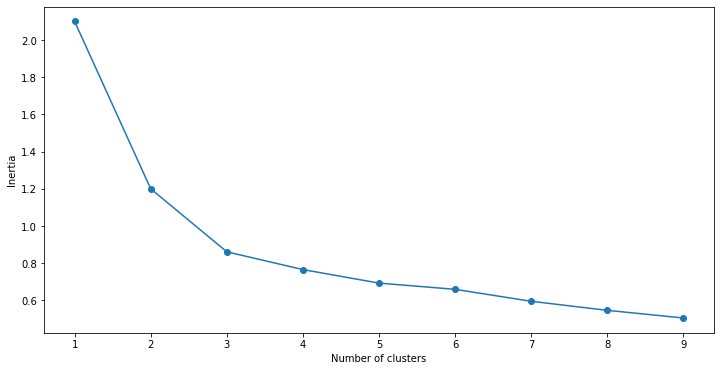

In [408]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
ar = 10
for cluster in range(1,ar):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(toronto_grouped_clustering)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,ar), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [409]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('srcNeighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [410]:
# add clustering labels
try:    
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except Exception as er:
    print(er)


In [411]:
neighborhoods_venues_sorted.rename(columns={"srcNeighborhood": "Neighborhood"}, inplace = True)

In [412]:
neighborhoods_venues_sorted[:2]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Bayview Village,Café,Clothing Store,Coffee Shop,Restaurant,Shopping Mall,Chinese Restaurant,Bakery,Burger Joint,Liquor Store,Spa
1,2,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Italian Restaurant,Coffee Shop,Bakery,Sandwich Place,Bank,Pub,Fast Food Restaurant,Asian Restaurant,Mobile Phone Shop


In [413]:
non_private_schools_merged = non_private_schools

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
non_private_schools_merged = non_private_schools_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [414]:
non_private_schools_merged[:5]

,name,school_type_desc,address_full,municipality,latitude,longitude,postalcode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Avondale Public School,Non Private,25 Bunty Lane,North York,43.776502,-79.385190,M2K,North York,Bayview Village,2,Café,Clothing Store,Coffee Shop,Restaurant,Shopping Mall,Chinese Restaurant,Bakery,Burger Joint,Liquor Store,Spa
1,Avondale Secondary Alternative School,Non Private,24 Silverview Dr,North York,43.786315,-79.411846,M2M,North York,"Willowdale, Newtonbrook",2,Korean Restaurant,Café,Dessert Shop,Coffee Shop,Bubble Tea Shop,Bank,Park,Intersection,Furniture / Home Store,Food Stand
2,Bala Avenue Community School,Non Private,6 Bala Ave,York,43.689471,-79.499016,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",2,Coffee Shop,Pizza Place,Convenience Store,Vietnamese Restaurant,Grocery Store,Gas Station,Furniture / Home Store,Asian Restaurant,Sandwich Place,Mexican Restaurant
3,Balmy Beach Community School,Non Private,14 Pine Ave,former Toronto,43.676436,-79.289827,M4E,East Toronto,The Beaches,2,Pub,Coffee Shop,Sandwich Place,Breakfast Spot,Pizza Place,Japanese Restaurant,Burger Joint,Grocery Store,Ice Cream Shop,Beach
4,Banting and Best Public School,Non Private,380 Goldhawk Trl,Scarborough,43.826673,-79.280154,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",2,Chinese Restaurant,Park,Bakery,Pizza Place,Bank,Discount Store,Coffee Shop,Japanese Restaurant,Steakhouse,Juice Bar


In [415]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],  zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

bad = []

try:

    for lat, lon, poi, cluster, name in zip(non_private_schools_merged ['latitude'], 
                                      non_private_schools_merged ['longitude'], 
                                      non_private_schools_merged ['Neighborhood'], 
                                      non_private_schools_merged['Cluster Labels'],
                                     non_private_schools_merged['name']):     
       

        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            tooltip = str(name)+ ','+'- Cluster ' + str(cluster),
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color= rainbow[cluster],
            fill_opacity=0.7).add_to(map_clusters)
            
except Exception as err:
    bad.append(err)
    

map_clusters



In [418]:
for n in range(0,4):
    
    cluster_df = non_private_schools_merged.loc[non_private_schools_merged['Cluster Labels'] == n, 
                     non_private_schools_merged.columns[[1] + list(range(0, non_private_schools_merged.shape[1]))]]
    
    if cluster_df.shape[0] >0:
        print(f'# -----------------------------------------------------')
        
        print(f"Number of schools in Cluster {n+1}: {cluster_df.shape[0]}")
        print(f'# -----------------------------------------------------\n')
        
        print(cluster_df['name'])
        

# -----------------------------------------------------
Number of schools in Cluster 1: 1
# -----------------------------------------------------

11    Ben Heppner Vocal Music Academy
Name: name, dtype: object
# -----------------------------------------------------
Number of schools in Cluster 2: 1
# -----------------------------------------------------

33    Blessed Pier Giorgio Frassati Catholic Element...
Name: name, dtype: object
# -----------------------------------------------------
Number of schools in Cluster 3: 55
# -----------------------------------------------------

0                                Avondale Public School
1                 Avondale Secondary Alternative School
2                          Bala Avenue Community School
3                          Balmy Beach Community School
4                        Banting and Best Public School
5                                Baycrest Public School
6                                 Bayview Middle School
7                   

In [417]:
for x in set(non_private_schools_merged['Cluster Labels']):
    dfset= non_private_schools_merged.loc[non_private_schools_merged['Cluster Labels'] == int(x), 
                     non_private_schools_merged.columns[[1] + list(range(5, non_private_schools_merged.shape[1]))]]
    
    print(dfset.shape)
        

(1, 16)
(1, 16)
(55, 16)


__Thank you__